<a href="https://colab.research.google.com/github/upadhyayprakash/eva4/blob/master/S6/EVA4_Session_6_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Session-6 Assignment**
I. Run the Model from Assignment-5, till 40 epochs, for each of the cases:
1. Without L1/L2 Regularization
2. With L1 Regularization
3. With L2 Regularization
4. With L1 and L2 Regularization

II. Draw 2 graphs for each of the 4 cases above,
1. Graph for accuracy change
2. Graph for loss change

III. Find 25 mis-classified images from L1 and L2 models respectively, show their actual and predicted class labels.


#### **RESULT**


In [0]:
# Load libraries

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Checking the MEAN and Standard Deviation of MNIST Data

simple_transforms = transforms.Compose([
  transforms.ToTensor()
])

mnist_data_source = datasets.MNIST('/home/prakash/Prakash/EVA4/Session-5/Notebooks/dataMNIST', train=True, download=True, transform=simple_transforms)
mnist_data = mnist_data_source.data
mnist_data_numpy = mnist_data_source.transform(mnist_data.numpy())

print('Stats for [Train] MNIST Data - MEAN and STD Calculation')
print(' - Numpy Shape:', mnist_data_source.data.cpu().numpy().shape)
print(' - Tensor Shape:', mnist_data_source.data.size())
print(' - min:', torch.min(mnist_data_numpy))
print(' - max:', torch.max(mnist_data_numpy))
print(' - mean:', torch.mean(mnist_data_numpy))
print(' - std:', torch.std(mnist_data_numpy))
print(' - var:', torch.var(mnist_data_numpy))

Stats for [Train] MNIST Data - MEAN and STD Calculation
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1306)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [0]:
# Define Data Transformation at Training and Testing phase

train_transformations = transforms.Compose([
  # transforms.Resize((28, 28)),
  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
  transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,)) # Calculated MEAN and Standard Deviation from MNIST data
])

test_transformations = transforms.Compose([
  # transforms.Resize((28, 28)),
  # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))
])

In [0]:
# Define Data Source

train_data_source = datasets.MNIST('/home/prakash/Prakash/EVA4/Session-5/Notebooks/dataMNIST', train=True, download=True, transform=train_transformations)
test_data_source = datasets.MNIST('/home/prakash/Prakash/EVA4/Session-5/Notebooks/dataMNIST', train=False, download=True, transform=test_transformations)

In [5]:
# Define Data Loaders

SEED = 1

# GPU(CUDA) Available?
cuda = torch.cuda.is_available() # returns True/False
print("GPU Available?", cuda)

torch.manual_seed(SEED)

if(cuda):
  torch.cuda.manual_seed(SEED)

# Defining Data Loader arguments as a dictionary, based on if GPU OR CPU usage
dataLoaderArguments = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# Train Data Loader
train_data_loader = torch.utils.data.DataLoader(train_data_source, **dataLoaderArguments)

# Test Data Loader
test_data_loader = torch.utils.data.DataLoader(test_data_source, ** dataLoaderArguments)

GPU Available? True


In [63]:
# Data Shape/Size

dataIter = iter(train_data_loader)
images, labels = dataIter.next()

print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])
tensor(3)


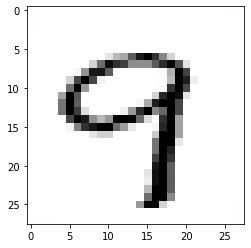

In [7]:
# Visualizing Single Image

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

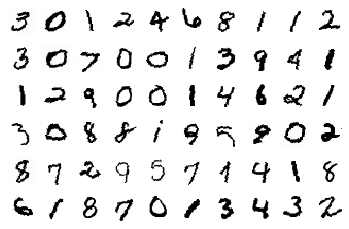

In [8]:
# Visualizing Multiple Images in Grid

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [0]:
# STEP-1: Defining the Basic MNIST Network Architecture
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input -? OUtput? RF
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 512, 3)
        self.conv6 = nn.Conv2d(512, 1024, 3)
        self.conv7 = nn.Conv2d(1024, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


In [0]:
# STEP-2: Defining the Modified MNIST Network Architecture with BatchNorm, Dropout, in Sequential model
import torch.nn.functional as F
dropout_value = 0.1
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=2)
        ) # output_size = 3

        self.convblocka = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblocka(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [11]:
# Model Summary: Used to know # of Parameters, Model Size Prediction, Network Architecure review.

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device Used: ", device)
model = MNISTNet().to(device)
summary(model, input_size=(1, 28, 28))

Device Used:  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]             900
             ReLU-12           [-1, 10, 10, 10]               0
      BatchNorm2d-13           [-1, 10, 10, 10]              20
          Dropout-14

In [0]:
# For Training Progress

from tqdm import tqdm

# **Without Regularization**

In [0]:
# Training without Regularization

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
from torch.optim.lr_scheduler import StepLR, LambdaLR # LR Scheduler

In [86]:
# # Model Training and Validation/Testing

model =  MNISTNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 40

scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_data_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_data_loader)
    

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.09169960021972656 Batch_id=468 Accuracy=88.79: 100%|██████████| 469/469 [00:08<00:00, 57.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0711, Accuracy: 9786/10000 (97.86%)

EPOCH: 1


Loss=0.16864871978759766 Batch_id=468 Accuracy=96.34: 100%|██████████| 469/469 [00:08<00:00, 54.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9871/10000 (98.71%)

EPOCH: 2


Loss=0.030003873631358147 Batch_id=468 Accuracy=97.00: 100%|██████████| 469/469 [00:09<00:00, 51.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9854/10000 (98.54%)

EPOCH: 3


Loss=0.07858774065971375 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:09<00:00, 48.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9878/10000 (98.78%)

EPOCH: 4


Loss=0.08199834078550339 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:09<00:00, 52.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9887/10000 (98.87%)

EPOCH: 5


Loss=0.03575421869754791 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:10<00:00, 45.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.04218432307243347 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:09<00:00, 48.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.07826145738363266 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:09<00:00, 48.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9922/10000 (99.22%)

EPOCH: 8


Loss=0.05975871905684471 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:09<00:00, 51.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9920/10000 (99.20%)

EPOCH: 9


Loss=0.034323737025260925 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:08<00:00, 52.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.024262411519885063 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:09<00:00, 47.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.04271306097507477 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:08<00:00, 53.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.0825609415769577 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:09<00:00, 50.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.030561789870262146 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:08<00:00, 52.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9921/10000 (99.21%)

EPOCH: 14


Loss=0.06055358052253723 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:09<00:00, 51.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9924/10000 (99.24%)

EPOCH: 15


Loss=0.12762118875980377 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:08<00:00, 52.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9925/10000 (99.25%)

EPOCH: 16


Loss=0.09875476360321045 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:08<00:00, 54.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9927/10000 (99.27%)

EPOCH: 17


Loss=0.0313277430832386 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:08<00:00, 53.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9928/10000 (99.28%)

EPOCH: 18


Loss=0.06942398101091385 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:09<00:00, 51.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9926/10000 (99.26%)

EPOCH: 19


Loss=0.04332055523991585 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:08<00:00, 54.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9927/10000 (99.27%)

EPOCH: 20


Loss=0.03461127355694771 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:08<00:00, 53.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9924/10000 (99.24%)

EPOCH: 21


Loss=0.06154555082321167 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:09<00:00, 52.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9928/10000 (99.28%)

EPOCH: 22


Loss=0.03894277289509773 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:08<00:00, 52.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9926/10000 (99.26%)

EPOCH: 23


Loss=0.03163967654109001 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:09<00:00, 48.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9925/10000 (99.25%)

EPOCH: 24


Loss=0.07778505235910416 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:10<00:00, 44.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9924/10000 (99.24%)

EPOCH: 25


Loss=0.012946009635925293 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:08<00:00, 53.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9925/10000 (99.25%)

EPOCH: 26


Loss=0.044619422405958176 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:08<00:00, 54.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9923/10000 (99.23%)

EPOCH: 27


Loss=0.10418646782636642 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:08<00:00, 55.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9923/10000 (99.23%)

EPOCH: 28


Loss=0.06350146979093552 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:08<00:00, 54.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9925/10000 (99.25%)

EPOCH: 29


Loss=0.018366500735282898 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:08<00:00, 55.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9923/10000 (99.23%)

EPOCH: 30


Loss=0.049073681235313416 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:08<00:00, 55.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9924/10000 (99.24%)

EPOCH: 31


Loss=0.07797064632177353 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:08<00:00, 52.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9922/10000 (99.22%)

EPOCH: 32


Loss=0.06998421996831894 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:09<00:00, 48.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9925/10000 (99.25%)

EPOCH: 33


Loss=0.02239277958869934 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:10<00:00, 45.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9924/10000 (99.24%)

EPOCH: 34


Loss=0.09686034917831421 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:09<00:00, 51.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9927/10000 (99.27%)

EPOCH: 35


Loss=0.01602991111576557 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:09<00:00, 49.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9924/10000 (99.24%)

EPOCH: 36


Loss=0.12259487062692642 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:09<00:00, 47.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9923/10000 (99.23%)

EPOCH: 37


Loss=0.035412225872278214 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:08<00:00, 52.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9923/10000 (99.23%)

EPOCH: 38


Loss=0.06023730710148811 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:08<00:00, 52.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9927/10000 (99.27%)

EPOCH: 39


Loss=0.06701909750699997 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:10<00:00, 44.88it/s]



Test set: Average loss: 0.0227, Accuracy: 9925/10000 (99.25%)



# **With L2 Regularization**

In [0]:
# Training with L2 REGULARIZATION

test_losses_l2_reg = []
test_acc_l2_reg = []

misClassified = []

def train_l2_reg(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  reg = 1e-6

  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    # Adding the Regularization L2 Loss
    l2_penalty = 0
    for param in model.parameters():
      l2_penalty += 0.5 * reg * torch.sum(torch.pow(param, 2))

    loss = loss + l2_penalty
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test_l2_reg(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    testDataIter = iter(test_loader)
    images, labels = testDataIter.next()

    with torch.no_grad():
        inc1 = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            targetList = target.tolist()
            predList = pred.tolist()
            for idx, label  in enumerate(targetList):
              if label != predList[idx][0]:
                misClassified.append(idx*inc1)
            
            # if inc1 == 0:
            #   print('Prediction is: ')
            #   print(pred)
            #   print('Target was: ')
            #   print(target)
            #   targetList = target.tolist()
            #   predList = pred.tolist()
            #   print(type(targetList))
            #   print(type(predList))
            #   for idx, label  in enumerate(targetList):
            #     print('label')
            #     print(label)
            #     print(predList[idx][0])
            #     if label != predList[idx][0]:
            #       misClassified.append(idx*inc1)
            #   print('misClassified')
            #   print(misClassified)
            
            inc1 = inc1 + 1
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_l2_reg.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_l2_reg.append(100. * correct / len(test_loader.dataset))

In [88]:
# Model Training and Validation/Testing

model_l2_reg =  MNISTNet().to(device)
optimizer = optim.SGD(model_l2_reg.parameters(), lr=0.01, momentum=0.9, weight_decay=0)

EPOCHS = 40

scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_l2_reg(model_l2_reg, device, train_data_loader, optimizer, epoch)
    scheduler.step()
    test_l2_reg(model_l2_reg, device, test_data_loader)
    

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.16641448438167572 Batch_id=468 Accuracy=87.06: 100%|██████████| 469/469 [00:10<00:00, 43.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0693, Accuracy: 9787/10000 (97.87%)

EPOCH: 1


Loss=0.053510718047618866 Batch_id=468 Accuracy=96.46: 100%|██████████| 469/469 [00:10<00:00, 45.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9864/10000 (98.64%)

EPOCH: 2


Loss=0.04439818114042282 Batch_id=468 Accuracy=97.09: 100%|██████████| 469/469 [00:10<00:00, 45.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9892/10000 (98.92%)

EPOCH: 3


Loss=0.07022298127412796 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:10<00:00, 44.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9905/10000 (99.05%)

EPOCH: 4


Loss=0.07045183330774307 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:09<00:00, 51.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.0833275318145752 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:09<00:00, 50.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Loss=0.0576186329126358 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:09<00:00, 49.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.0943925678730011 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:09<00:00, 47.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

EPOCH: 8


Loss=0.051225967705249786 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:09<00:00, 48.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9926/10000 (99.26%)

EPOCH: 9


Loss=0.021546879783272743 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:10<00:00, 46.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.05026035010814667 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:10<00:00, 45.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.02160487323999405 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:09<00:00, 47.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9924/10000 (99.24%)

EPOCH: 12


Loss=0.028961770236492157 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:10<00:00, 43.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.03681834787130356 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:11<00:00, 41.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9928/10000 (99.28%)

EPOCH: 14


Loss=0.0962318405508995 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:10<00:00, 44.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9929/10000 (99.29%)

EPOCH: 15


Loss=0.02173779346048832 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:09<00:00, 50.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9929/10000 (99.29%)

EPOCH: 16


Loss=0.03699136897921562 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:11<00:00, 40.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9928/10000 (99.28%)

EPOCH: 17


Loss=0.10251615941524506 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:11<00:00, 42.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9930/10000 (99.30%)

EPOCH: 18


Loss=0.02334696054458618 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:10<00:00, 42.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9928/10000 (99.28%)

EPOCH: 19


Loss=0.043268393725156784 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:11<00:00, 41.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9933/10000 (99.33%)

EPOCH: 20


Loss=0.17138877511024475 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:09<00:00, 47.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9928/10000 (99.28%)

EPOCH: 21


Loss=0.05271602421998978 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:11<00:00, 40.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9928/10000 (99.28%)

EPOCH: 22


Loss=0.02696787565946579 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:11<00:00, 40.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9928/10000 (99.28%)

EPOCH: 23


Loss=0.025346839800477028 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:10<00:00, 44.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9925/10000 (99.25%)

EPOCH: 24


Loss=0.020599745213985443 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:10<00:00, 44.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9931/10000 (99.31%)

EPOCH: 25


Loss=0.08981333673000336 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:09<00:00, 47.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9929/10000 (99.29%)

EPOCH: 26


Loss=0.05060754716396332 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:11<00:00, 41.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9930/10000 (99.30%)

EPOCH: 27


Loss=0.08890911191701889 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:09<00:00, 50.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9926/10000 (99.26%)

EPOCH: 28


Loss=0.08770858496427536 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:10<00:00, 44.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9928/10000 (99.28%)

EPOCH: 29


Loss=0.07659351825714111 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:10<00:00, 46.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9927/10000 (99.27%)

EPOCH: 30


Loss=0.03223060443997383 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:09<00:00, 49.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9931/10000 (99.31%)

EPOCH: 31


Loss=0.03775899484753609 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:10<00:00, 44.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9927/10000 (99.27%)

EPOCH: 32


Loss=0.0447862483561039 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:10<00:00, 45.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9928/10000 (99.28%)

EPOCH: 33


Loss=0.04362057149410248 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:10<00:00, 44.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9928/10000 (99.28%)

EPOCH: 34


Loss=0.15001097321510315 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:10<00:00, 45.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9926/10000 (99.26%)

EPOCH: 35


Loss=0.034722600132226944 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:09<00:00, 48.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9930/10000 (99.30%)

EPOCH: 36


Loss=0.010503043420612812 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:10<00:00, 43.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9932/10000 (99.32%)

EPOCH: 37


Loss=0.03525203838944435 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:11<00:00, 42.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9929/10000 (99.29%)

EPOCH: 38


Loss=0.01528205443173647 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:11<00:00, 42.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9928/10000 (99.28%)

EPOCH: 39


Loss=0.05738542601466179 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:09<00:00, 47.90it/s]



Test set: Average loss: 0.0206, Accuracy: 9928/10000 (99.28%)



# **Visualization**

45
40


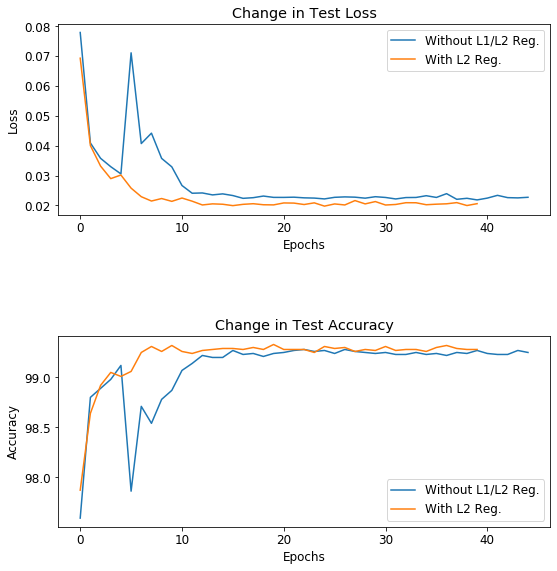

In [89]:
# Visualizing Training and Testing Results

# Styling the Plot Axes Typography
font = {'size'   : 12}
plt.rc('font', **font)

fig, axs = plt.subplots(2,1,figsize=(10,10))

fig.tight_layout(pad=8.0)

axs[0].set_title("Change in Test Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
print(len(test_losses))
print(len(test_losses_l2_reg))
axs[0].plot(test_losses, label="Without L1/L2 Reg.")
# axs[0].plot(test_losses, label="With L1 Reg.")
axs[0].plot(test_losses_l2_reg, label="With L2 Reg.")
# axs[0].plot(test_losses, label="With L1 & L2 Reg.")

axs[0].legend()

axs[1].set_title("Change in Test Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")

axs[1].plot(test_acc, label="Without L1/L2 Reg.")
# axs[1].plot(test_acc, label="With L1 Reg.")
axs[1].plot(test_acc_l2_reg, label="With L2 Reg.")
# axs[1].plot(test_acc, label="With L1 & L2 Reg.")

axs[1].legend()

# **Mis-Classified Images**

[0, 2, 5, 6, 8, 9, 11, 12, 14, 15, 16, 18, 20, 21, 22, 24, 28, 30, 32, 33, 34, 35, 36, 37, 38]


<ipython-input-92-e3b1b7f512fd>:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(pad=2.0)


IndexError: ignored

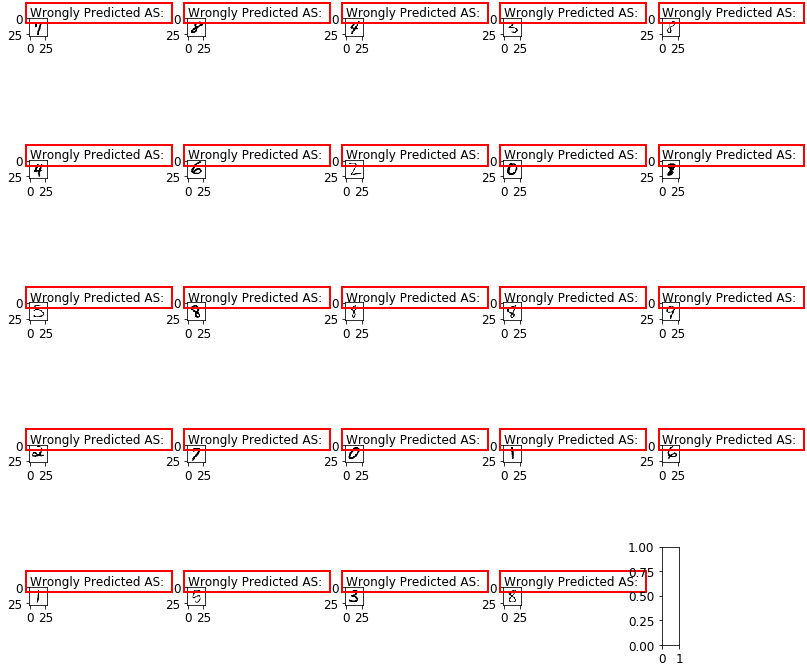

In [92]:
# Calculating 25 wrong Label indexes
wrongLabelSet = set(misClassified)
wrongLabelIndexes = list(wrongLabelSet)
wrongLabelIndexes.sort()
print(wrongLabelIndexes[:25])
finalWrongLabels = wrongLabelIndexes[:25]

testDataIter = iter(test_data_loader)
images_test, labels_test = testDataIter.next()

num_of_result = 26
plt.rcParams["figure.figsize"] = (10,10)
for index in range(1, num_of_result + 1):
    plt.subplot(5, 5, index)
    # plt.axis('off')
    plt.tight_layout(pad=2.0)
    plt.imshow(images_test[finalWrongLabels[index]].numpy().squeeze(), cmap='gray_r')
    plt.text(1, -3, 'Wrongly Predicted AS: ', bbox=dict(fill=False, edgecolor='red', linewidth=2))



### **Labels index of the Test Data Array which have not Matched the target and predicted  labels**

In [85]:
# print(misClassified)
wrongLabelSet = set(misClassified)
wrongLabelIndexes = list(wrongLabelSet)
wrongLabelIndexes.sort()
print(wrongLabelIndexes[:25])

[0, 8, 21, 23, 64, 66, 84, 108, 112, 118, 120, 124, 147, 150, 240, 261, 270, 275, 284, 285, 288, 297, 320, 333, 364]
